# Maze solver with reinforced learning

In [497]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import defaultdict
from time import time
import imageio.v2 as imageio
from IPython import display
import os

In [498]:
allowed_actions = {'D':[1,0],'U':[-1,0],'R':[0,1],'L':[0,-1]}

## Maze generator
Function takes maze shape (X,Y), objects to be generated (by default 0-normal, 1- wall) and their probability (80/20) \
It always makes points (0,0) - begining and (X,Y) - end walkable.

In [499]:
def generate_maze(X, Y, objects, probability):
        if len(objects) != len(probability):
            print(f'[Error] Objects and probability have different number of items.')
            return None
        elif np.sum(probability) != 1.0:
            print(f'[Error] Sum of probabilities does not equal 1.0.')
            return None
        else:
            maze = np.random.choice(objects,(X,Y),p=probability)
            maze[0,0] = 0
            maze[X-1,Y-1] = 0
            return maze

## Maze class
It is responsible for doing everything thats connected directly to maze. 

### Functions find_allowed_steps, check_move, move_value,
After being initialised it generates dictionary of all possible moves. For example \
|----------------------------- \
|-Position: 0,0                 \
|   |- D -> Cost: 1             \
|   |- R -> Cost: 100           \
It is possible to print *allowed_steps* by calling **print_allowed_steps** function.

### Updating maze
After calling **update_maze** function with choosen action it:
1. Updates current robot posiotion
   1. Also it checks if its possible to do the action. Its useful when updating maze manually.
2. It gets the *reward* of the action
3. Finally it appends the move to the *steps* list which includes the history of all steps taken by the robot.
Function returns current *robot state* and *reward*.

### Reseting maze
Calling **return_results_and_reset** returns move history (*steps*) along with *score* of the epoche. \
Then it resets *score*, *steps* and *robot position*.

### Printing maze
It is possible to call **show_maze** function to visualise current state of maze. \
Function recreates all steps taken of the robot and then prints plot of the maze.


In [500]:
class Maze:
    def __init__(self, maze,specials_points={0:1,1:100}):
        self.maze = maze
        self.special_points = specials_points       #Dict containing points for each of the objects
        self.Y,self.X = [i-1 for i in maze.shape]   #Size of maze -1 because we start from (0,0)
        self.robot_position = (0,0)                 #Current position of robot
        self.steps = []                             #All steps taken by robot
        self.score = 0
        self.allowed_steps = defaultdict(list)      #List of allowed stapes
        self.find_allowed_steps()                   #Construct dict of possible steps along with cost

    def check_move(self, y, x, action):
        y += allowed_actions[action][0]
        x += allowed_actions[action][1]

        if x < 0 or y < 0 or x > self.X or y > self.Y:
            return False
        else:
            return True
    
    def move_value(self, y, x, action):
        y += allowed_actions[action][0]
        x += allowed_actions[action][1]
        return self.special_points[self.maze[y,x]]
    
    def check_game_over(self):
        if self.robot_position == (self.Y,self.X):
            return True
        else:
            return False
    
    def find_allowed_steps(self):
        for y in range(self.Y+1):
            for x in range(self.X+1):
                for action in allowed_actions:
                    if self.check_move(y,x,action):
                        self.allowed_steps[(y,x)].append(action)
    
    def print_allowed_steps(self):
        string_size = 30
        print('|' + '-'*(string_size-1))
        for k, v in self.allowed_steps.items():
            string = f'Position: {k[0]},{k[1]}'
            for action in v:
                string += '\n'
                string += f'|   |- {action} -> Cost: {self.move_value(k[0],k[1],action)}'
            print('|-' + string)
        print('|' + '-'*(string_size-1))
        return self.allowed_steps

    def update_maze(self,action):
        y, x = self.robot_position
        if self.check_move(y, x, action):
            reward = self.move_value(y,x,action)
            self.score += self.move_value(y,x,action)
            y += allowed_actions[action][0]
            x += allowed_actions[action][1]
            self.robot_position = (y,x)
            self.steps.append(action)
            #print(self.score)
        else:
            print('Move imposible.')
        return self.robot_position, reward
    
    def return_results_and_reset(self):
        result_score = self.score
        result_steps = self.steps
        self.score = 0
        self.steps = []
        self.robot_position = (0,0)
        return result_score, result_steps
    
    
    def show_maze(self):
        col = ['white','red','lightblue','orange','grey','darkred','teal','darkorange','black']
        cmap = colors.ListedColormap(col)
        bounds = [0,1,2,3,4,5,6,7,8]
        norm = colors.BoundaryNorm(bounds,cmap.N)
        maze_copy = self.maze.copy()
        maze_copy_copy = self.maze.copy()
        y, x = (0,0)
        for action in self.steps:
            maze_copy[(y,x)] = maze_copy_copy[(y,x)] + 4
            y += allowed_actions[action][0]
            x += allowed_actions[action][1]
            maze_copy[(y,x)] = len(col)-1
        plt.figure()
        im = plt.imshow(maze_copy,interpolation='none', aspect='equal',
                        cmap=cmap,norm=norm)
        ax = plt.gca()
        # Major ticks
        ax.set_xticks(np.arange(0, self.X+1, 1))
        ax.set_yticks(np.arange(0, self.Y+1, 1))
        # # Minor ticks
        ax.set_xticks(np.arange(-.5, self.X+1, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.Y+1, 1), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)

## Agent class
Class responsible for learning robot to solve the maze.\
The goal of the robot is to minimize *reward*, so be as close to *target* (0) as possible.

### Expected reward
The agent starts with calling **init_reward** function which generates table (*G*) of random expected rewards for each move. The reward are between 0.1 to max(special_points).

### Loss function
After each epoche agent updates expected reward for each state using this formula:
$$ G_{state} = G_{state} + \alpha(target-G_{state})$$
Where $\alpha$ is learning rate and $target$ is the target reward. So this formula adds some percantage of difference between actual reward and expected reward.

### Learning

Function **learn** is responsible for updating the values of *G* (basically learning). It knows the target (because we minimize we chose 0)  and updates values using formula above. 

### Choosing action
To choose an action agent firstly decides between exploring and exploiting the maze. \
Exploring makes agent go to random directions to explore rewards in the maze. \
Exploiting means that the agent will choose an action where reward will be the lowest. \
We set the algorythm to explore 20% of the time but we will decrease this number over time as the agent learns rewards in the maze.

In [501]:
class Agent:
    def __init__(self, states,special_points, alpha=0.15, random_factor=0.2):
        self.special_points = special_points
        self.state_history = [[(0,0),0]]
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_rewards(states)
        
    def init_rewards(self, states):
        #Initialize random state table 
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(i,j)] = np.random.uniform(high=max(self.special_points.values()), low=0.1)

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))
    
    def learn(self):
        target = 0                                                          # we know the "ideal" reward
        a = self.alpha
        for state, reward in reversed(self.state_history):
            self.G[state] = self.G[state]+ a * (target - self.G[state])
        self.state_history = []                                             # reset the state_history
        self.random_factor -= 10e-5                                         # decrease random_factor

    def choose_action(self, state, allowed_moves):
        next_move = None
        if np.random.random() < self.random_factor:
            next_move = np.random.choice(allowed_moves)
        else:
            maxG = -10e15                                                   # some really small random number
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, allowed_actions[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

In [502]:
def print_epoche_results(i, t, score, steps_taken):
    #Funtion that prints results of each epoch
    string_len = 16
    epoche_string = f'Epoche {i}'
    epoche_string = epoche_string + " "*(string_len-len(epoche_string)-1) + ' | '

    score_string = f'Score: {score}'
    score_string = score_string + " "*(string_len-len(score_string)-1) + ' | '

    steps_string = f'Steps: {len(steps_taken)}'
    steps_string = steps_string + " "*(string_len-len(steps_string)-1) + ' | '

    time_string = f'Time: {np.round(t,4)}'
    time_string = time_string + " "*(string_len-len(time_string)-1) + ' | '

    print('| '+epoche_string+score_string+steps_string+time_string)

In [503]:
def check_stop_condition(best_result, best_epoch, score, epoch, stop_after = 200):
    #Stop learning after given number of iterations without better result
    
    if best_result > score:
        best_result = score
        best_epoch = epoch
        return False, best_result, best_epoch
    elif epoch - best_epoch == stop_after:
        return True, best_result, best_epoch
    else:
        return False, best_result, best_epoch

In [504]:
def recreate_game(steps,maze):
    filenames = []
    maze_copy = maze.copy()
    col = ['white','red','lightblue','orange','grey','darkred','teal','brown','black']
    cmap = colors.ListedColormap(col)
    bounds = [0,1,2,3,4,5,6,7,8,9]
    norm = colors.BoundaryNorm(bounds,cmap.N)
    Y, X = maze.shape
    y, x = (0,0)
    for index, action in enumerate(steps):
        maze[(y,x)] = maze_copy[(y,x)] + 4
        y += allowed_actions[action][0]
        x += allowed_actions[action][1]
        maze[(y,x)] = len(col)-1
        plt.figure(figsize=(X,Y))
        im = plt.imshow(maze,interpolation='none', aspect='equal',
                        cmap=cmap,norm=norm)
        ax = plt.gca()
        # Major ticks
        ax.set_xticks(np.arange(0, X, 1))
        ax.set_yticks(np.arange(0, Y, 1))
        # # Minor ticks
        ax.set_xticks(np.arange(-.5, X, 1), minor=True)
        ax.set_yticks(np.arange(-.5, Y, 1), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
        # Remove minor ticks
        ax.tick_params(which='minor', bottom=False, left=False)
        #Colorbar
        cbar = plt.colorbar(im,shrink=0.75)
        cbar.set_ticks(bounds)
        cbar.set_ticklabels(["","Path", "Wall", "Boost", "Slowdown", 'Walked\npath','Walked\nwall', 'Walked\nboost', 'Walked\nslowdown', 'Current\nposition'])
        filenames.append(f'{index}.png')
        plt.savefig(os.path.join('img',f'{index}.png'))
    return filenames

In [505]:
def generate_gif(filenames, name='result.gif', frame_duration = 0.1):
    with imageio.get_writer(name, mode='I', duration = frame_duration) as writer:
        for filename in filenames:
            image = imageio.imread(os.path.join('img',filename))
            writer.append_data(image)

    for filename in filenames:
        os.remove(os.path.join('img',filename)) 

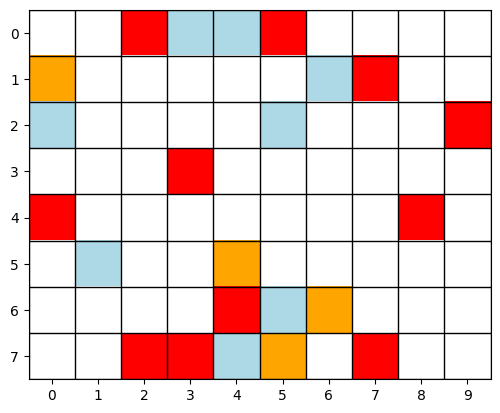

In [506]:
X, Y = 8, 10
special_points = {0:1,1:100,2:0.5,3:10}
results = {}
maze = generate_maze(X,Y,list(special_points.keys()),[0.65,0.2,0.1,0.05])
maze = Maze(maze, special_points)
robot = Agent(maze.maze,special_points, alpha=0.1, random_factor=0.25)
maze.show_maze()

## Main loop

In [507]:
epoches = 10000
best_result = 0
best_epoch = epoches
overall_time = time()
for i in range(epoches):
    print('| '+('-'*16+'| ')*4)
    t = time()
    while not maze.check_game_over():    
        state = maze.robot_position        
        action = robot.choose_action(state, maze.allowed_steps[state])      # Choose an action (explore or exploit)
        state, reward = maze.update_maze(action)                            # Update maze state
        robot.update_state_history(state, reward)                           # Update robot memory and reward
        if len(maze.steps) > 1000:                                          # If robot cannot reach the end in given time move it to the end
            maze.robot_position = (maze.Y, maze.X)
            
    robot.learn()                                                          
    score, steps_taken = maze.return_results_and_reset()                    # Return result and reset maze
    if best_result == 0:                                                    # Check stop condition
        best_result = score
        best_epoch = i
    else:
        stop, best_result, best_epoch = check_stop_condition(best_result, best_epoch, score, i,epoches//2)
        if stop:
            print(f'Learning stopped. The best score has not been improved for {i-best_epoch} epochs.')
            break
    results[score] = steps_taken                                            # Update best scores
    print_epoche_results(i, time()-t, score,steps_taken)                    # Print epoche results
print(f'Learning was done in {time()-overall_time} seconds')

| ----------------| ----------------| ----------------| ----------------| 
| Epoche 0        | Score: 28287.5  | Steps: 1001     | Time: 0.0184    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 1        | Score: 2143.5   | Steps: 200      | Time: 0.0055    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 2        | Score: 13800.5  | Steps: 352      | Time: 0.0046    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 3        | Score: 2168.5   | Steps: 378      | Time: 0.0064    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 4        | Score: 2314.5   | Steps: 192      | Time: 0.0018    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 5        | Score: 6455.0   | Steps: 1001     | Time: 0.0122    | 
| ----------------| ----------------| ----------------| ----------------| 
| Epoche 6        | Score

In [508]:
best_steps = results[min(results.keys())]
print(f'Best score is {best_result} achieved in {len(results[best_result])} steps in epoche {best_epoch}')
print(f'Steps taken to win:')
for step in best_steps:
    print(f'->',end=' ')
    print(f'{step}',end=' ')
print('')

Best score is 15.5 achieved in 16 steps in epoche 97
Steps taken to win:
-> R -> D -> D -> R -> R -> R -> R -> R -> D -> D -> R -> D -> R -> D -> D -> R 


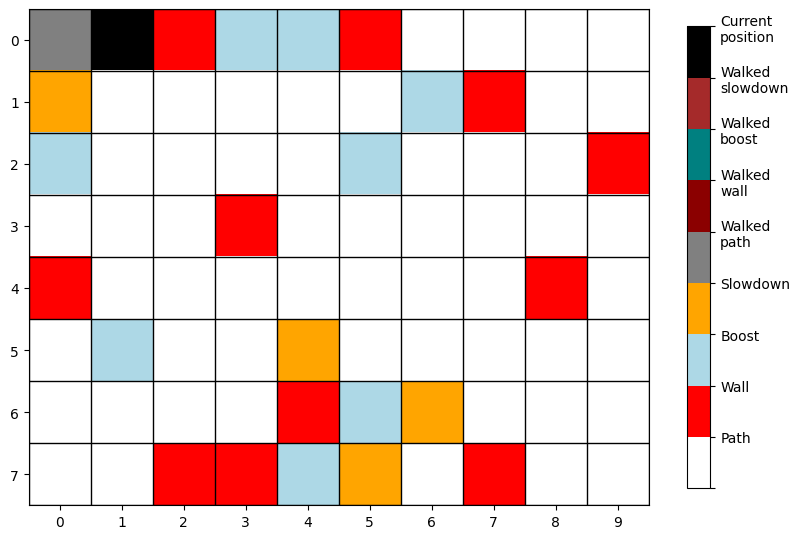

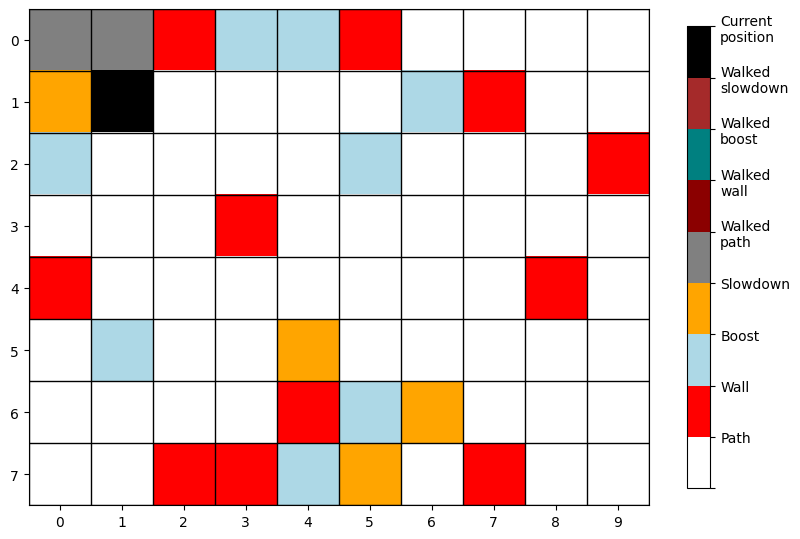

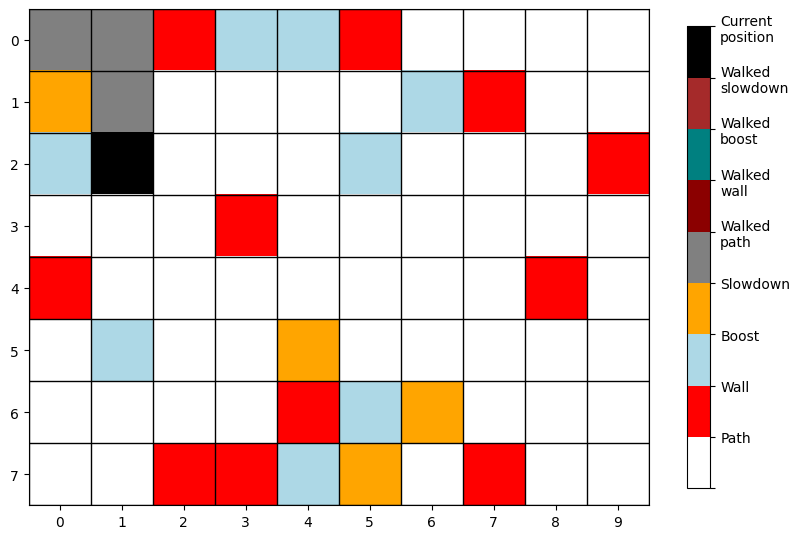

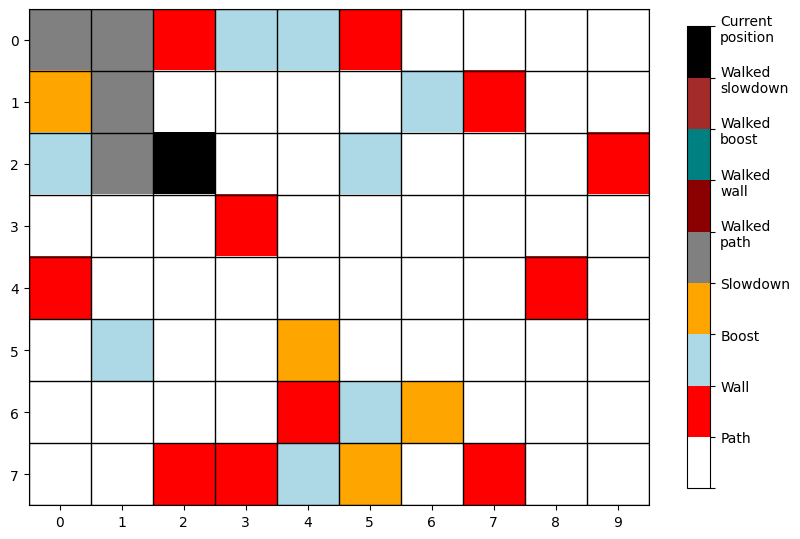

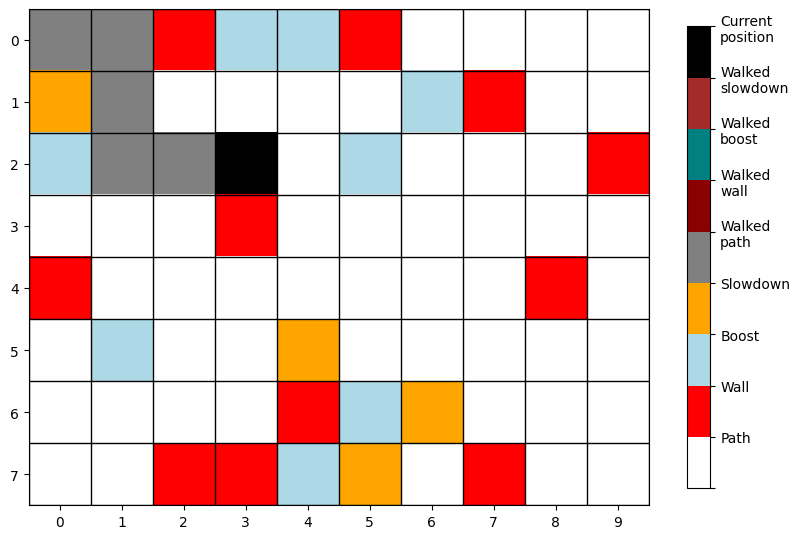

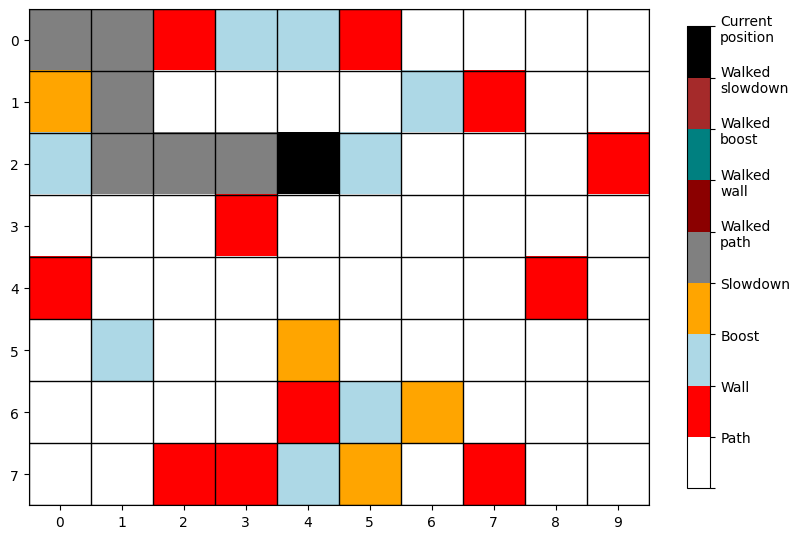

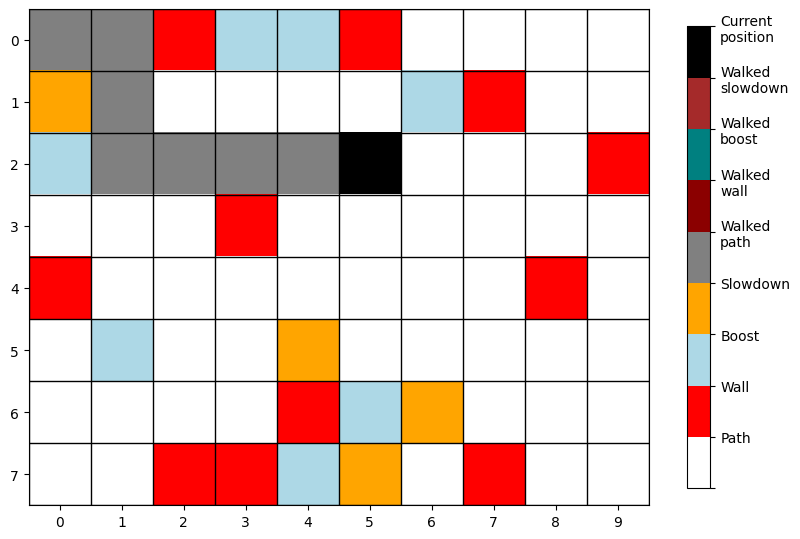

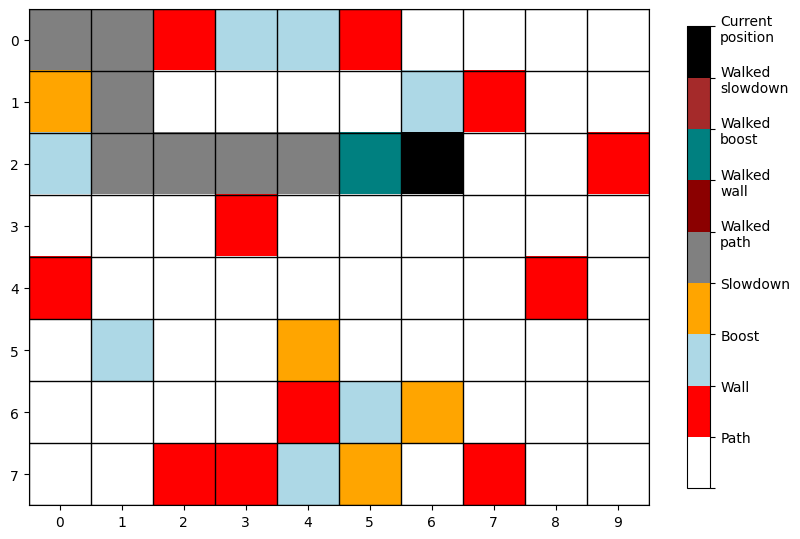

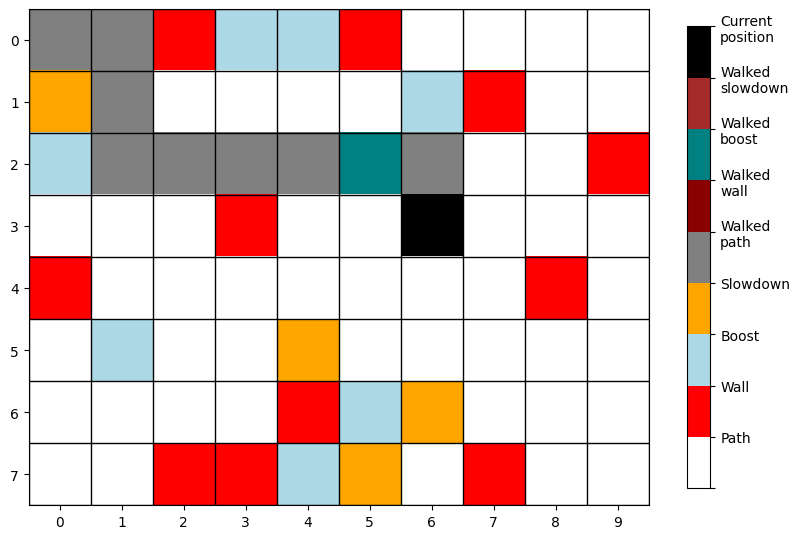

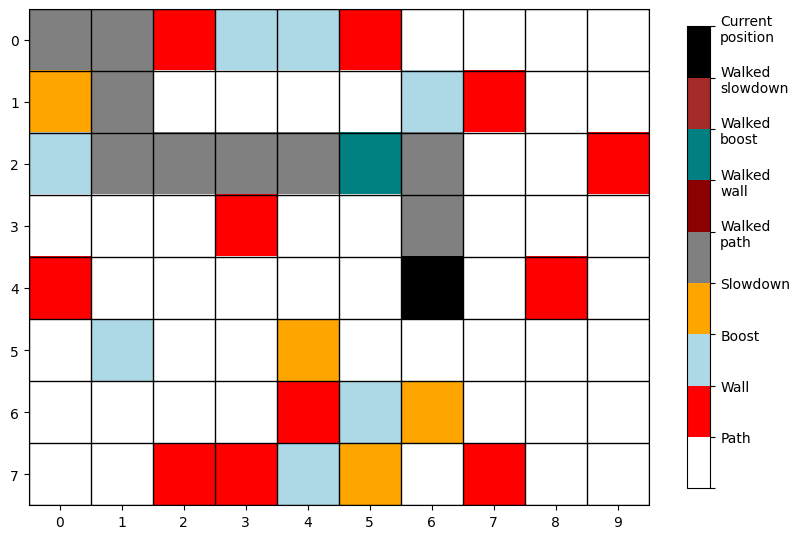

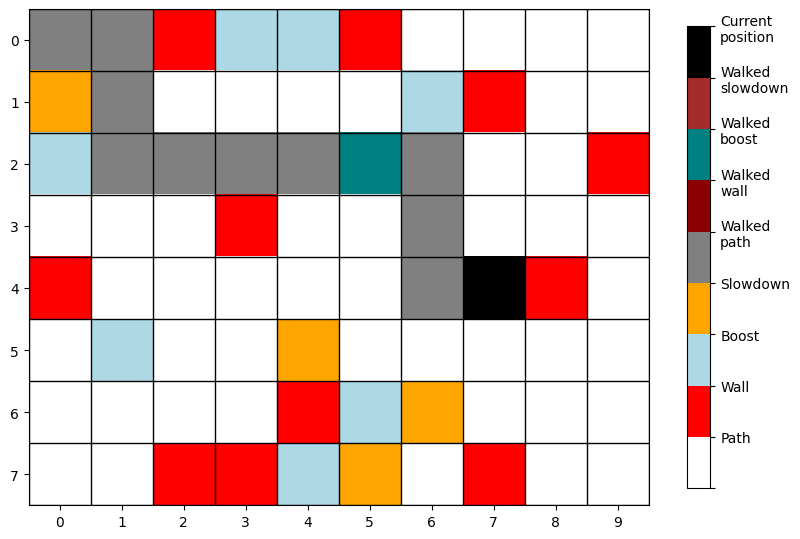

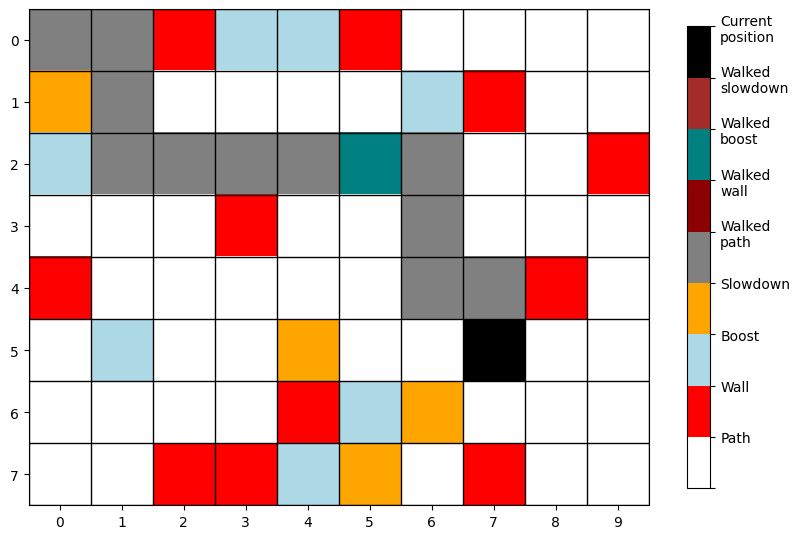

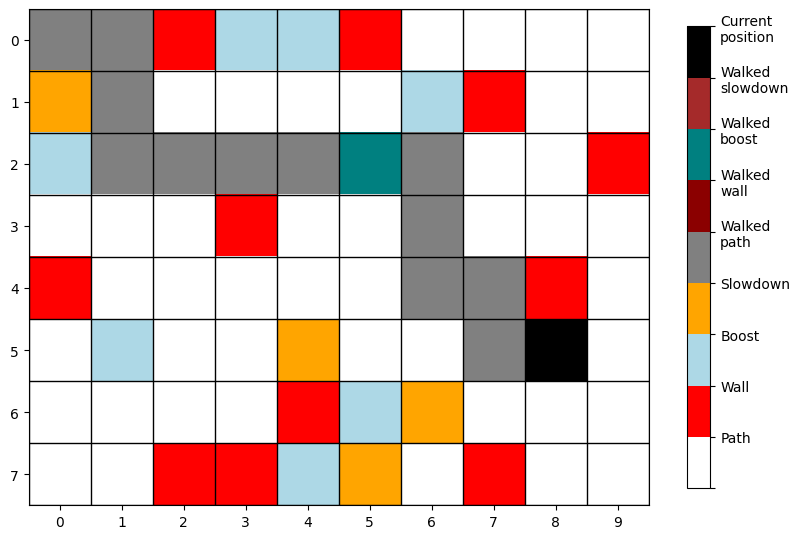

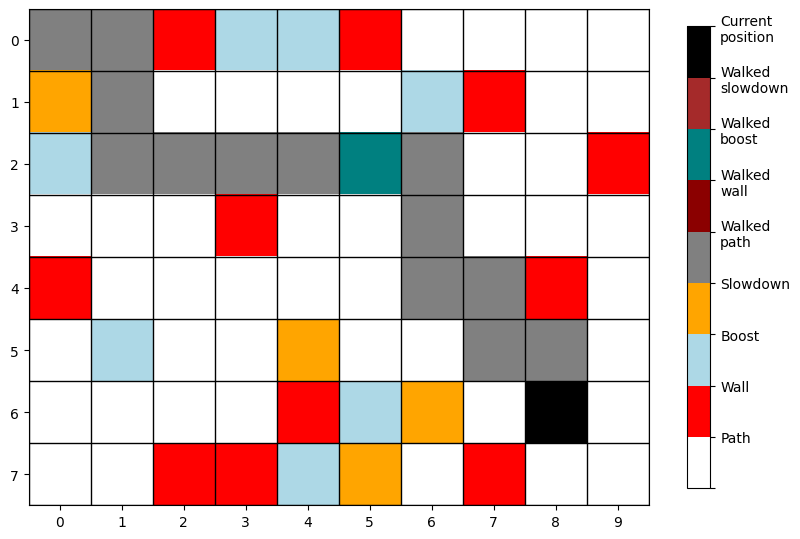

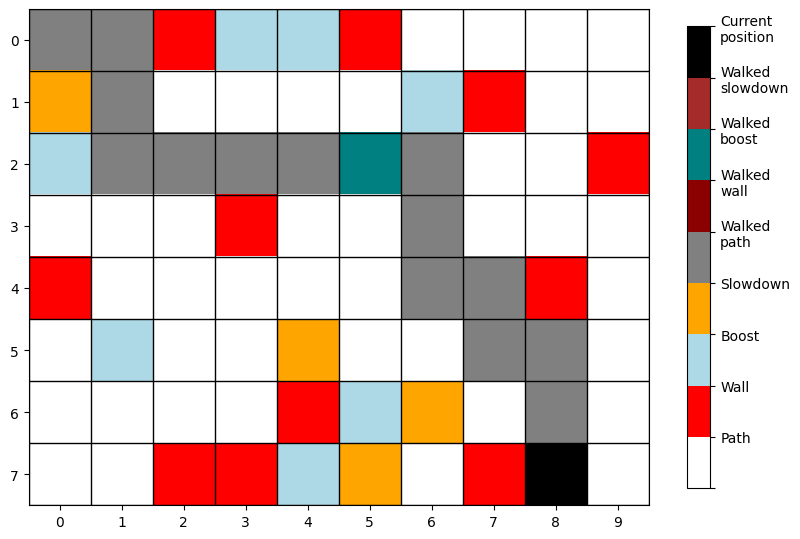

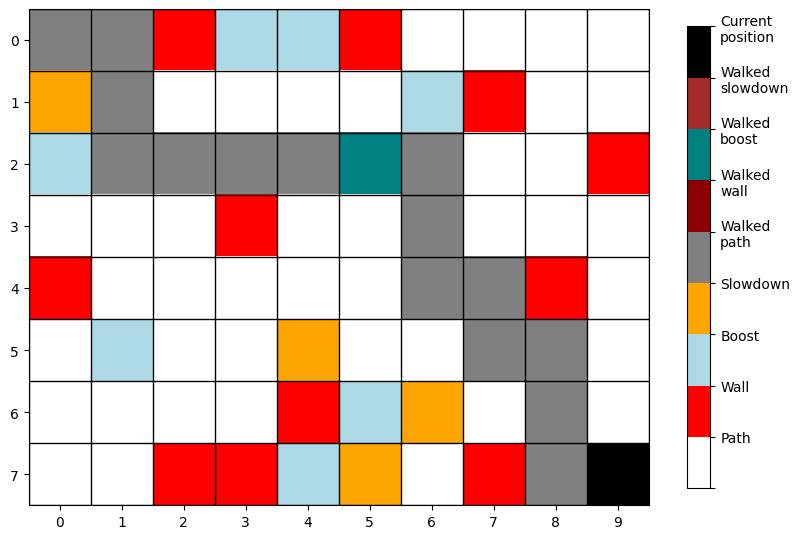

In [509]:
name = 'result.gif'
filenames = recreate_game(best_steps,maze.maze)

In [510]:
generate_gif(filenames, name,0.3)

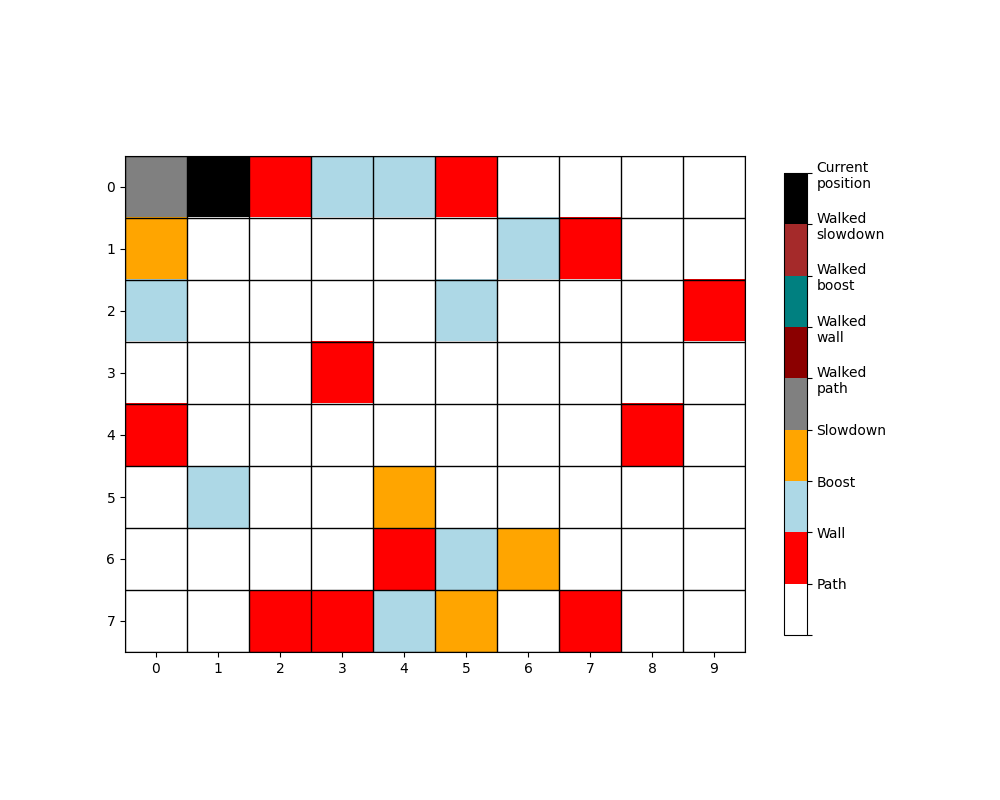

In [511]:
display.Image(data=open(name,'rb').read(), format='png')